In [16]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [24]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # Tokenization
        temp_X = [word for word in temp_X if not word in stopwords]  # Stopword removal
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # Tokenization
        temp_X = [word for word in temp_X if not word in stopwords]  # Stopword removal
        X_test.append(temp_X)
    
    # Construct the vocabulary
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)  # Reserve 4 for special tokens

    # Add special tokens
    vocab = ['<PAD>', '<UNK>', '<BOS>', '<EOS>'] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

In [27]:
### 모델구성 3가지 이상 ####  -----첫번째 cnn 방식
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [29]:
x_val = x_train[:20000]   
y_val = y_train[:20000]

partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=25  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/25
247/247 [==============================] - 5s 6ms/step - loss: 0.6921 - accuracy: 0.5163 - val_loss: 0.6894 - val_accuracy: 0.5380
Epoch 2/25
247/247 [==============================] - 1s 5ms/step - loss: 0.6880 - accuracy: 0.5440 - val_loss: 0.6853 - val_accuracy: 0.5565
Epoch 3/25
247/247 [==============================] - 1s 5ms/step - loss: 0.6866 - accuracy: 0.5472 - val_loss: 0.6846 - val_accuracy: 0.5598
Epoch 4/25
247/247 [==============================] - 1s 5ms/step - loss: 0.6858 - accuracy: 0.5494 - val_loss: 0.6839 - val_accuracy: 0.5606
Epoch 5/25
247/247 [==============================] - 1s 5ms/step - loss: 0.6848 - accuracy: 0.5535 - val_loss: 0.6839 - val_accuracy: 0.5611
Epoch 6/25
247/247 [==============================] - 1s 5ms/step - loss: 0.6844 - accuracy: 0.5540 - val_loss: 0.6831 - val_accuracy: 0.5617
Epoch 7/25
247/247 [==============================] - 1s 5ms/step - loss: 0.6835 - accuracy: 0.5560 - val_loss: 0.6831 - val_accuracy: 0.5602
Epoch 

In [31]:
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.6865 - accuracy: 0.5566


In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


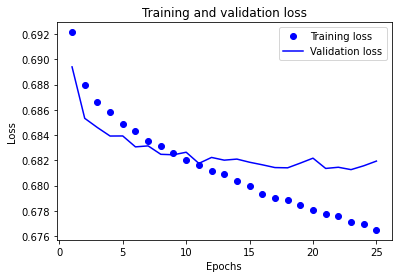

In [33]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

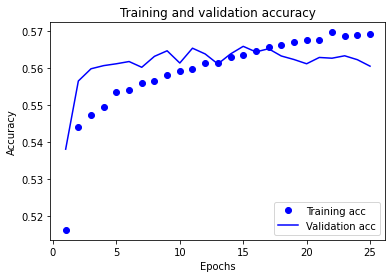

In [34]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
#### 모델구성 2번째 방식 --- GlobalMaxPooling1D 방식 (간단한 모델)
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [36]:
x_val = x_train[:20000]   
y_val = y_train[:20000]

partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=25  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/25
247/247 [==============================] - 1s 4ms/step - loss: 0.6920 - accuracy: 0.5341 - val_loss: 0.6907 - val_accuracy: 0.5449
Epoch 2/25
247/247 [==============================] - 1s 3ms/step - loss: 0.6902 - accuracy: 0.5422 - val_loss: 0.6896 - val_accuracy: 0.5449
Epoch 3/25
247/247 [==============================] - 1s 3ms/step - loss: 0.6897 - accuracy: 0.5422 - val_loss: 0.6894 - val_accuracy: 0.5449
Epoch 4/25
247/247 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5422 - val_loss: 0.6894 - val_accuracy: 0.5449
Epoch 5/25
247/247 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5422 - val_loss: 0.6894 - val_accuracy: 0.5444
Epoch 6/25
247/247 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5421 - val_loss: 0.6894 - val_accuracy: 0.5444
Epoch 7/25
247/247 [==============================] - 1s 4ms/step - loss: 0.6896 - accuracy: 0.5425 - val_loss: 0.6894 - val_accuracy: 0.5444
Epoch 

In [38]:
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 2s - loss: 0.6902 - accuracy: 0.5379


In [42]:
####### 모델3(LSTM) ###########
vocab_size = 20000  # Increased vocab size
word_vector_dim = 128  # Increased word embedding dimension

model = tf.keras.Sequential()

# Embedding layer
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

# Bidirectional LSTM layer with more units
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)))

# Dense layers with dropout for regularization
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model with an optimizer and a suitable learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,667,137
Trainable params: 2,667,137
Non-trainable params: 0
_________________________________________________________________


In [43]:
x_val = x_train[:20000]   
y_val = y_train[:20000]

partial_x_train = x_train[20000:]  
partial_y_train = y_train[20000:]

In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=25  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/25
247/247 [==============================] - 9s 26ms/step - loss: 0.4313 - accuracy: 0.7980 - val_loss: 0.3453 - val_accuracy: 0.8496
Epoch 2/25
247/247 [==============================] - 6s 23ms/step - loss: 0.3209 - accuracy: 0.8649 - val_loss: 0.3343 - val_accuracy: 0.8558
Epoch 3/25
247/247 [==============================] - 6s 23ms/step - loss: 0.2879 - accuracy: 0.8788 - val_loss: 0.3317 - val_accuracy: 0.8563
Epoch 4/25
247/247 [==============================] - 6s 24ms/step - loss: 0.2594 - accuracy: 0.8898 - val_loss: 0.3466 - val_accuracy: 0.8571
Epoch 5/25
247/247 [==============================] - 6s 24ms/step - loss: 0.2343 - accuracy: 0.9010 - val_loss: 0.3730 - val_accuracy: 0.8551
Epoch 6/25
247/247 [==============================] - 6s 24ms/step - loss: 0.2127 - accuracy: 0.9118 - val_loss: 0.3869 - val_accuracy: 0.8565
Epoch 7/25
247/247 [==============================] - 6s 24ms/step - loss: 0.1931 - accuracy: 0.9201 - val_loss: 0.4326 - val_accuracy: 0.8559

In [45]:
results = model.evaluate(x_test,  y_test, verbose=2)

1537/1537 - 6s - loss: 1.3045 - accuracy: 0.8350


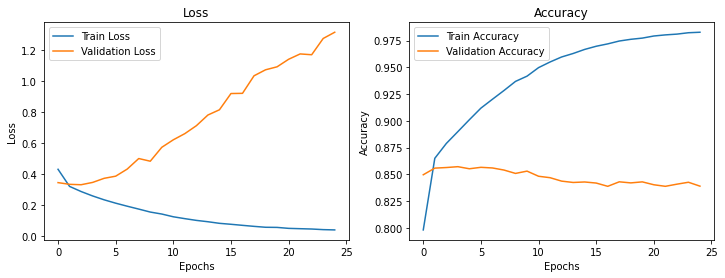

In [48]:
def plot_history(history):
    # Loss 시각화
    plt.figure(figsize=(12, 4))
    
    # Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 그래프 출력
    plt.show()

# 그래프 시각화 호출
plot_history(history)

In [49]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(20000, 128)


In [53]:
###### word2vec #########
import pandas as pd
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
vector = word_vectors.wv['끝']


EOFError: Ran out of input

In [ ]:
############ 회고 ##############
word2vec 적용못했는데 심사숙고하여 코드를 작성하여 잘 하겠습니다. ㅎㅎ